# Run the NCA model (in `nca_model.py`)
Use the xf kernel

In [1]:
import random, configparser
import torch
import matplotlib.pyplot as plt
import numpy as np
from nca_model import CA
import os
from matplotlib.animation import FuncAnimation, HTMLWriter
from image_utils import plot_CA, plot_two_CAs, plot_layers, plot_losses
from image_utils import add_alpha_channel, apply_alpha_mask, bw_to_rgb, np_to_tens
from image_utils import normalize_bw_tensor_image
from image_utils import plot_combined, print_img_props
from utils import alert, init_grid_specified_inits, find_min_max

model_dir = "./models/"
out_dir = './out/'


/bigdrive/anaconda3/envs/xf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CELL_DIM = 16


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')


device is cuda


In [3]:
from drawing_app import get_drawing_from_ui

target_source = "mnist" # "drawing", "mnist", "png"

new_drawing = False # If true, fire up the Tk interface; if false, use saved image

# NOTE: make sure config.ini has the appropriate dimensions!

if target_source == "drawing":
    if new_drawing:
        image = get_drawing_from_ui()
        print_img_props(image, "new Tk dwg")
        np.save('drawing.npy', image)

    else:
        image = np.load('drawing_alpha_gecko.npy')
        print_img_props(image, "Tk dwg from file")

    target = np_to_tens(image)
    target = apply_alpha_mask(target) #.to(device)
    print_img_props(target, "Tk target")


elif target_source == "mnist":

    from torchvision import datasets, transforms

    # Define the transform to apply to the input data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize the data
    ])

    # Load the MNIST dataset
    mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    # Get a single image from the dataset
    image, label = mnist_data[5]

    target = normalize_bw_tensor_image(image)
    target = bw_to_rgb(target)
    target = add_alpha_channel(target)
    print_img_props(target, "MNIST target")


elif target_source == "png": # use_png
    from PIL import Image
    from torchvision import transforms

    # Open the image file
    image_file = Image.open("seeking-manifold-icon-50.png")
#    image_file = Image.open("bye-28.png")

    # Convert to torch.Tensor
    image = transforms.ToTensor()(image_file)

    # add alpha channel (will elegantly handle case where image already has one)
    image = add_alpha_channel(image)

    target = apply_alpha_mask(image)
    print_img_props(target, "PNG target")


else:
    print(f'Unknown target source {target_source}')


target.to(device)



MNIST target
Image type: <class 'torch.Tensor'>
Image dtype: torch.float32
Image shape: torch.Size([4, 28, 28])
Image min, max: 0.0, 1.0
Image mean: 0.361


/bigdrive/anaconda3/envs/xf/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/bigdrive/anaconda3/envs/xf/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 

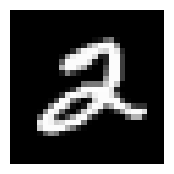

In [4]:
plot_CA(target, size=(2, 2))


In [5]:
print(f'target shape = {target.shape}')
print(f'upper left pixel RGB: {target[:3, 0, 0]}') # 0. is black, 1. is white
print(f'upper left pixel alpha channel: {target[3, 0, 0]}')

target shape = torch.Size([4, 28, 28])
upper left pixel RGB: tensor([0., 0., 0.])
upper left pixel alpha channel: 1.0


state_grid shape = torch.Size([1, 16, 28, 28])

temp shape = torch.Size([1, 4, 28, 28])


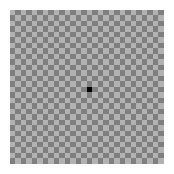

In [6]:
# Some setup
config = configparser.ConfigParser()
config.read('config.ini')

X_DIM = int(config['main']['X_DIM'])
Y_DIM = int(config['main']['Y_DIM'])
CELL_DIM = int(config['main']['CELL_DIM'])
HIDDEN_DIM = int(config['main']['HIDDEN_DIM'])
KERNEL_SIZE = int(config['main']['KERNEL_SIZE'])
N_CHAN = int(config['main']['N_CHAN'])

# Instantiate the CA
ca = CA(device=device).to(device)

# # Function to create a starting state_grid with a single starting pixel
# # Note: x is down, y is right
# def init_grid(batch_size=1, cell_dim=16, x_dim=28, y_dim=28, x_init=14, y_init=14):
#     # This is zeros in non-visible except center = ones
# #    state_grid = torch.zeros((1, CELL_DIM, X_DIM, Y_DIM), dtype=torch.float32)
#     state_grid = torch.zeros((batch_size, cell_dim, x_dim, y_dim), dtype=torch.float32)
#     # Center starting px
# #    state_grid[0, 3, X_DIM//2, Y_DIM//2] = 1.
# #    state_grid[0, 3, 11, Y_DIM//2] = 1.
#     state_grid[0, 3, x_init, y_init] = 1.
#     return state_grid

# Initialize the state_grid just for plotting purposes
#state_grid = init_grid().to(device)
x_inits = [14]
y_inits = [14]
batch_size = len(x_inits)
state_grid = init_grid_specified_inits(batch_size=batch_size, x_inits=x_inits, y_inits=y_inits).to(device)

print(f'state_grid shape = {state_grid.shape}')
print()

# # Plot the starting grid
# temp = ca.extract_visible_grid(state_grid).cpu()
temp = ca.extract_visible_grid_batch(state_grid).cpu()
# print(f'temp[:, 0, 0] = {temp[:, 0, 0]}')
print(f'temp shape = {temp.shape}')
# plot_CA(temp)

for i in range(len(x_inits)):
    plot_CA(temp[i], size=(2, 2))


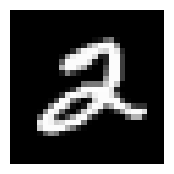

In [7]:
plot_CA(target.cpu(), size=(2, 2))

## Training

In [8]:
n_training_steps = 400 # outer loop
batch_size = 64 # 64 for 28x28; 16 - 32 for 50x50; 8 for 100x100; 2 for 200x200
ca_steps_min = 64 # 64 for 28x28; 96 for 50x50
ca_steps_max = 96 # 96 for 28x28; 128 for 50x50

# Set up optimizer and scheduler
optimizer = torch.optim.Adam(ca.parameters(), lr=5e-3)
use_scheduler = True

if use_scheduler:
    T_max = 2*n_training_steps  # Adjust this based on the total number of epochs you are training for
    eta_min = 0  # Minimum learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)


Training step 200, latest loss: 0.037,
cumulative loss: 0.084 with 81 CA steps


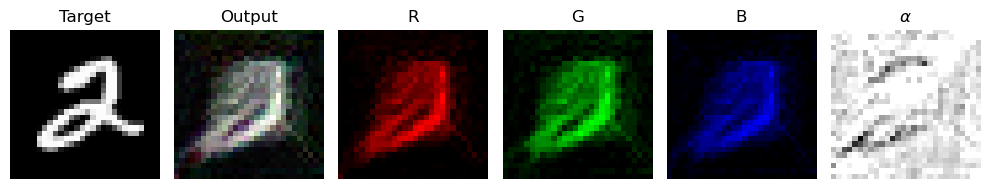

Training step 400, latest loss: 0.017,
cumulative loss: 0.063 with 96 CA steps


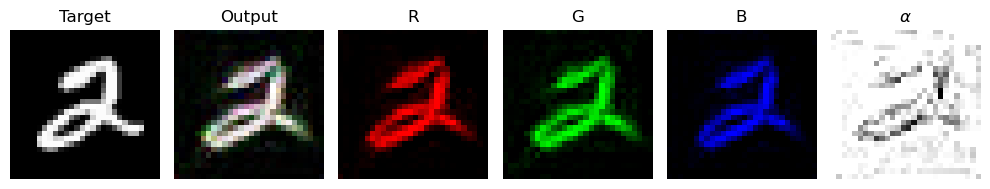

Playing WAVE '/usr/lib/libreoffice/share/gallery/sounds/apert.wav' : Signed 16 bit Little Endian, Rate 22050 Hz, Mono


In [9]:

# Troubleshooting backprop errors:
#torch.autograd.set_detect_anomaly(True)

#losses_detailed_cumulative = []
losses_latest = []
losses = []
ca_steps = []

# Outer Train loop
for tstep in range(n_training_steps):

    # (Re)initialize state grid
#    state_grid = init_grid(batch_size=batch_size, x_init=5, y_init=15).to(device)

    # Do each item in the batch with a different initial state
    # x_inits is a list of x coordinates for each item in the batch, ranging from
    # 0 to X_DIM-1
    # x_inits = np.random.randint(0, X_DIM-1, batch_size)
    # y_inits = np.random.randint(0, Y_DIM-1, batch_size)
    # Troubleshooting <- Note: the x, y of the starting point is
    # NOT the same as the x, y offset for target!
    # (x, y) = (14, 14) for init px corresponds to (0, 0) for target offset
    x_inits = [X_DIM//2] * batch_size
    y_inits = [Y_DIM//2] * batch_size

    state_grid = init_grid_specified_inits(x_inits, y_inits,
                                           batch_size=batch_size,
                                           cell_dim=CELL_DIM,
                                           x_dim=X_DIM,
                                           y_dim=Y_DIM).to(device)

    target_batch = torch.zeros(batch_size, 4, X_DIM, Y_DIM).to(device)
    for i in range(batch_size):
        # CA: the shift target approach is no longer used
        # Now we have to make corresponding offsets to the respective targets
        # temp = shift_image(target, x_inits[i]- (X_DIM // 2), y_inits[i] - (Y_DIM // 2))
        # target_batch[i] = temp
        target_batch[i] = target

    # Zero gradients
    optimizer.zero_grad()

    # Random number of CA steps each time
    n_ca_steps = random_int = random.randint(ca_steps_min, ca_steps_max)

    # Initialize loss
    loss = 0.

# Inner CA step loop
    for step in range(n_ca_steps):
        
        # Take a step
        state_grid, visible_grid_batch = ca.forward(state_grid)

        # Compute the loss (using broadcasting)
        latest_loss = torch.mean((target_batch - visible_grid_batch) ** 2)
        loss = loss + latest_loss

    # Normalize for number of CA steps
    loss = loss / n_ca_steps

    losses_latest.append(latest_loss.item())
    losses.append(loss.item())
    ca_steps.append(n_ca_steps)
    
    loss.backward() # Cumulative loss for the whole inner loop 

    # Update the parameters
    optimizer.step()
    if use_scheduler:
        # Step the scheduler to adjust the learning rate
        scheduler.step()


    if (tstep+1) % 200 == 0:
        print(f"Training step {tstep+1}, latest loss: {latest_loss.item():.3f},\ncumulative loss: {loss.item():.3f} with {n_ca_steps} CA steps")
        plot_combined(target_batch[0].cpu(), visible_grid_batch[0].detach().cpu(), size=(10, 5))

# Let me know when training is done
alert()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


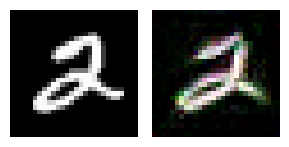

In [10]:
plot_two_CAs(target_batch[0], visible_grid_batch[0], size=(3, 2))

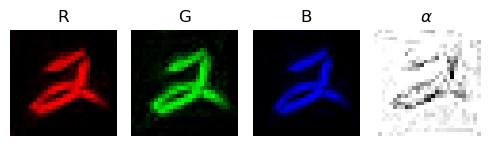

In [11]:
plot_layers(visible_grid_batch[0].detach().cpu(), size=(5, 2))

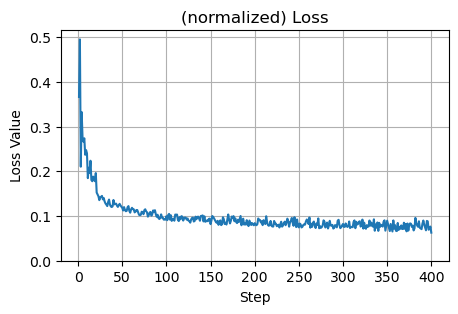

In [12]:
plot_losses(losses, size=(5, 3), title="(normalized) Loss")
#plot_losses(losses, ymax=0.125, size=(5, 3), title="(normalized) Loss")


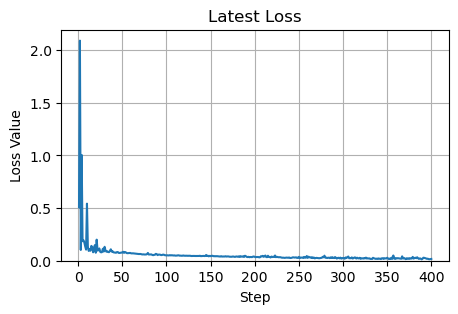

In [13]:
plot_losses(losses_latest, size=(5, 3), title="Latest Loss")
#plot_losses(losses_latest, ymax=0.2, size=(5, 3), title="Latest Loss")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


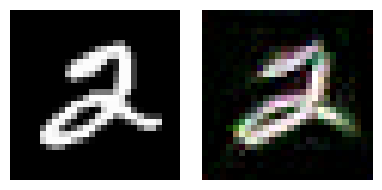

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


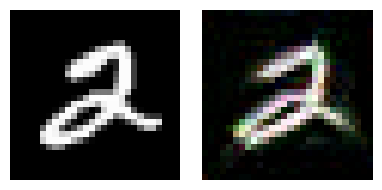

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


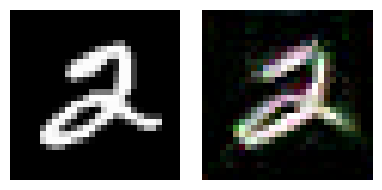

In [14]:
for i in range(3):
    plot_two_CAs(target_batch[i], visible_grid_batch[i], size=(4, 2))


In [15]:
torch.save(ca, os.path.join(model_dir, 'ca_model.pt'))


## Inference

In [16]:
from IPython.display import HTML

# If you need to load a previously-saved model:
#ca = torch.load(os.path.join(model_dir, 'ca_model.pt'))
#ca = torch.load(os.path.join(model_dir, 'ca_model_gecko.pt'))

ca.eval()


CA(
  (grad_x_conv2d): FixedDepthwiseConv2d()
  (grad_y_conv2d): FixedDepthwiseConv2d()
  (identity_conv2d): FixedDepthwiseConv2d()
  (layer1): Linear(in_features=48, out_features=128, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=128, out_features=16, bias=True)
)

In [17]:
# Initialize the state_grid

batch_size = 1
num_iters = 100 # 400
x_inits = [X_DIM//2] * batch_size
y_inits = [Y_DIM//2] * batch_size

state_grid = init_grid_specified_inits(x_inits, y_inits,
                                        batch_size=batch_size,
                                        cell_dim=CELL_DIM,
                                        x_dim=X_DIM,
                                        y_dim=Y_DIM).to(device)


# List to store frames
frames = []

def update_plot(frame_num, frames, img_plot):
    img_plot.set_data(frames[frame_num])
    return [img_plot]

# Loop over model iterations
for i in range(num_iters):
    # Process with the model
    state_grid, visible_grid_batch = ca.forward(state_grid)
    
    # Convert visible_grid to numpy for plotting
    # Assuming visible_grid is in the form (batch, channels, height, width) and channels = 4 (RGBA)
    numpy_grid = visible_grid_batch[0].detach().cpu().numpy().transpose((1, 2, 0))
    numpy_grid = np.clip(numpy_grid, 0, 1)  # Ensure the pixel values are valid
    
    # Store frame
    frames.append(numpy_grid)


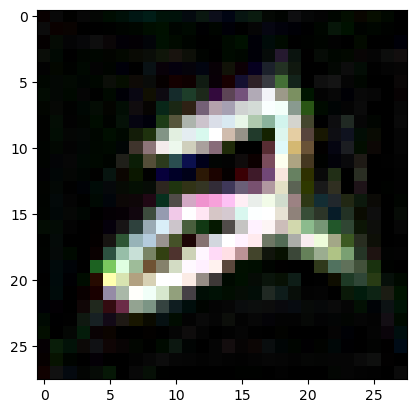

In [18]:
# Create figure and axes
fig, ax = plt.subplots()
img_plot = ax.imshow(frames[0], interpolation='nearest')

ani = FuncAnimation(fig, update_plot, frames=len(frames), fargs=(frames, img_plot), interval=50, blit=True, repeat=False)

# Save the animation as an HTML file so we can display it here (saving to mp4 is cell below)
ani.save(os.path.join(out_dir, 'animation.html'), writer=HTMLWriter(fps=20)) # works! Open .html in browser. Frames stored as separate files
HTML(ani.to_jshtml())


In [19]:
# Let me know when the animation is done.
# Keep this in a separate cell from the above, otherwise it messes up the animation!
alert()

Playing WAVE '/usr/lib/libreoffice/share/gallery/sounds/apert.wav' : Signed 16 bit Little Endian, Rate 22050 Hz, Mono


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


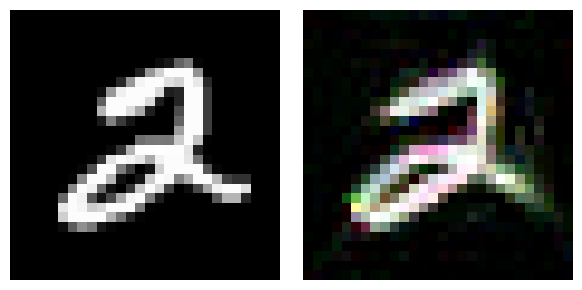

In [20]:
plot_two_CAs(target, visible_grid_batch[0], size=(6, 3))

## Save the animation as an MP4

In [21]:
# Tried a bunch of options to save animation as an MP4, finally one worked (the ffmpeg in xf env is
# maybe old or doesn't include some codecs?)

#ani.save(os.path.join(out_dir, 'animation.gif'), writer='ffmpeg', dpi=100) # [libopenh264 @ 0x55bbdcb71300] Incorrect library version loaded
#ani.save(os.path.join(out_dir, 'animation.gif'), writer='mencoder', dpi=100) # MovieWriter mencoder unavailable; using Pillow instead. then ValueError: unknown file extension: .mp4
#ani.save(os.path.join(out_dir, 'animation.gif'), writer='pillow', dpi=100) # ValueError: unknown file extension: .avi
#ani.save(os.path.join(out_dir, 'animation.gif'), writer='ffmpeg', dpi=200) # creates a large file but with only the starting frame!
#ani.save(os.path.join(out_dir, 'animation.gif'), writer='imagemagick', dpi=200) # convert-im6.q16: no images defined `animation.mp4' @ error/convert.c/ConvertImageCommand/3229.
#ani.save(os.path.join(out_dir, 'animation.gif'), writer='ffmpeg', dpi=200, extra_args=['-vcodec', 'libx264']) # Unknown encoder 'libx264'

#from matplotlib.animation import FFMpegWriter # No worky
#writer = FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)
#ani.save(os.path.join(out_dir, 'animation.gif'), writer=writer) # Incorrect library version loaded

# Works! <- but doesn't render in Obsidian
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=20, metadata=dict(artist='Chris Armstrong'), bitrate=1800, codec='mpeg4')
# ani.save(os.path.join(out_dir, 'animation.mp4'), writer=writer)

# Works, but takes almost 7 min and results in a file of size 19 MB (compared to maybe 2 min / 2 MB for ffmpegwriter)
# from matplotlib.animation import ImageMagickWriter
# writer = ImageMagickWriter(fps=20)
# ani.save(os.path.join(out_dir, 'animation.gif'), writer=writer)

# Works! Quick, under 20 sec, and results in a file of size 6 MB <- but no controls <- convert to MP4 per below
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=20)
ani.save(os.path.join(out_dir, 'animation.gif'), writer=writer)

# then on CL (no conda env) do something like this:
# ffmpeg -i animation.gif -c:v libx264 -preset medium -crf 23 -c:a aac -b:a 192k -pix_fmt yuv420p animation.mp4

